### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2023 ###

### Final Course Project: Due 5/5/23

# Autonomous Vehicles Control using PID and MPC Controllers  #

#### NEVINDU BATAGODA (batagoda@wis.edu)
#### ISHAAN MAHAJAN (imahajan@wisc.edu) 


*****

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Mathematical Model](#2.-Mathematical-model)
1. [Solution](#3.-Solution)
1. [Results and Discussion](#4.-Results-and-discussion)
  1. [Optional Subsection](#4.A.-Feel-free-to-add-subsections)
1. [Conclusion](#5.-Conclusion)

## 1. Introduction ##
This project is inspired by our work as members of Wisconsin Autonomous student organization. We are part of a university team competing in the AutoDrive Challenge II competition organized by SAE International and General Motors. The goal of this competition is to build a self-driving car capable of navigating urban environments.

As part of the control stack of the self-driving car, there are three planners: 1) The High-Level planner which creates a set of target waypoints to follow, 2) The Mid Level planner which generates a smooth trajectory from the waypoints and 3) A Low-Level planner, which uses a feedback control algorithm to generate a target velocity and heading which is then passed into the vehicle as a throttle and a steering input.

In this project, we plan to address the problem of the Low-Level Planner of the Wisconsin Autonomous control stack. Our objective is to find a suitable controller that will be able to handle various urban driving scenarios such as obstacle avoidance. To that end, we implement and design two controllers,

1. [Proportional Integral Derivative (PID) Controller](https://en.wikipedia.org/wiki/PID_controller) -  A feedback control mechanism that regulates a process by adjusting its inputs based on error signals
2. [Model Predictive Controller (MPC) ](https://en.wikipedia.org/wiki/Model_predictive_control) - An advanced feedback control that uses a mathematical model to predict future behavior and optimize control action

In order to evaluate the performance of our controllers we test them on several different trajectories and obstacle avoidance scenarios. The data for the trajectories are from the [Autonomy Research Test Bed (ART)](https://arxiv.org/abs/2211.04886) of UW-Madison [Simulation-Based Engineering Laboratory](https://sbel.wisc.edu/).

In the [2nd Section](#1.-Mathematical-model) we give an overview of the mathematics behind the vehicle dynamics model we use, the PID controller and the MPC controller.  In the [3rd Section](#3.-Solution) we provide the Julia-based implementation of our controllers, and in the [4th Section](#4.-Results-and-discussion) we conduct an evaluation of our results.






## 2. Mathematical model ##

### 2.1 The 2D Bicycle Model ###

The kinematic bicycle model is a simplified representation used for modeling the dynamics of vehicles and is widely used in control systems. It is called a "bicycle model" because it reduces a four-wheeled vehicle to a two-wheeled representation, focusing on the vehicle's center of mass and treating the front and rear wheels as if they were a single point each. The model assumes that the vehicle moves in a flat plane and that there is no tire slip. It also ignores forces like aerodynamics and friction for simplicity. Even though it is a simplified model, the bicycle model works well for our purposes. The bicycle model has 4-Degrees of Freedom and is described as follows.

Let our state variable be $\textbf{x}_t = [x\, y\, \psi \, v]$, which contains the current position, heading angle $(\psi)$ and the velocity $v$.

Let our control inputs be $\textbf{u}_t = [a \; \delta]$. which contains the acceleration input($a$) and the steering angle input ($u$/

Hence for a give input state $\textbf{x}_t$ and a give control input $\textbf{u}_t$ at time $t$, the bicycle model $f(\textbf{x}_t,\textbf{u}_t)$, can be used to determine the next state $\textbf{x}_{t+1}$,

$$\textbf{x}_{t+1} = \textbf{x}_{t} + f(\textbf{x}_t,\textbf{u}_t) \Delta t \\
\text{where, } \quad  f(\textbf{x}_t,\textbf{u}_t) =  \begin{bmatrix}
v\cos(\psi) \\
v\sin(\psi) \\
\frac{v\tan(\delta)}{L} \\
a 
\end{bmatrix}
$$

Here $L$ is the length of the vehicle, or rather the distance between the front and rear wheels of the bicycle model.

![bicyle-model][bicycle]




#### 2.2 Proportional Derivative Integral (PID) Controller ###

PID control is a widely used feedback control algorithm in various engineering applications, such as process control, robotics, and automation systems. The primary objective of a PID controller is to minimize the error between a desired setpoint and a measured process variable, thereby regulating the system output to achieve the desired performance. PID control consists of Proportional, Derivative, and Integral components. The mathematical formulation is as follows,


$$ \textbf{u(t)} =  K_p \textbf{e(t)} + K_i \int_{0}^{t} \textbf{e($\tau$)} d\tau + K_d \frac{d\textbf{e(t)}}{dt}$$

Where,  $K_p,K_i,K_d \geq 0 $ are the PID gain coefficients and are usually tuned manually. They each control the influence of the proportional, integral, and derivative terms respectively.

Here, $\textbf{e(t)}$ is the error between the target state $r(t)$ and the measured process state, $y(t)$, 
$$e(t) = r(t) - y(t) $$

The target states are ususally produced by some sort of a motion planning algorithm.

The output, $\textbf{u(t)}$ of the PID controller, is the neccessary control inputs required to acheive the target state.

A diagram of the PID controller is shown below ![pid-control][pid]


[bicycle]: https://www.researchgate.net/publication/318810853/figure/fig1/AS:526533921120256@1502546877982/Kinematic-bicycle-model-of-the-vehicle.png

[pid]: https://plcynergy.com/wp-content/uploads/2021/01/PID-controller.jpg


#### 2.3 Model Predictive Control (MPC) ###

Model Predictive Control (MPC) [[paper]](https://arxiv.org/abs/2304.09156) is an advanced control strategy used in control system engineering. The main idea behind MPC is to optimize the control actions over a finite prediction horizon using a mathematical model of the system, taking into account constraints on inputs, outputs, and states. MPC aims to minimize a cost function, which represents the desired performance objectives, such as meeting a reference target or minimizing energy consumption.

At each time steps, MPC finds the next $T$ set of control inputs ($\textbf{u}_{1:T}$) needed to meet the next $T$ target states($\textbf{x}_t^{ref}$) of the trajectory. It does this by solving the following optimization problem, 


$$ \min\limits_{\textbf{x}_{1:T},\textbf{u}_{1:T}} \quad J(\textbf{x}_{1:T},\textbf{u}_{1:T}) \\
\text{subject to, } \textbf{x}_{t+1} =   \textbf{x}_{t} + f(\textbf{x}_t,\textbf{u}_t) \Delta t \quad \forall t \in [T-1]\\
\textbf{u}_t \in \mathcal{U}_t \quad \forall t \in [T] \\
\textbf{x}_t \in \mathcal{X}_t \quad \forall t \in [T] \\
\textbf{x}_1 = \textbf{x}_\text{init}
$$
 
Where, $f(\textbf{x}_t,\textbf{u}_t)$ is the bicycle dynamics model defined above, $\textbf{x}_t$ is the state at time $t$, $\textbf{u}_t$ is the control inputs at time $t$, $\mathcal{U}_t$ are the set of constraints for the control inputs and $\mathcal{X}_t$ is the set of constraints for the state variables.

For example, one can constraint the control inputs to have a certain minimum and maximum acceleration and steering angle. And one can also set constraints to the state vectors to avoid certain obstacles.

And finally, the objective function of the optimization problem is defined as follows,

$$  J(x_{1:T},u_{1:T}) = \textbf{e}_t^T Q \textbf{e}_t + \textbf{u}_t^T R \textbf{u}_t$$

Where, in the first term,  $\textbf{e}_t = \textbf{x}_t - \textbf{x}_t^{ref}$ is the measurement error vector, and $Q$ is a diagonal matrix that contains the penalties for each term in the state vector. The second term is the cost for applying control inputs, $R$ is a diagonal matrix that has penalties for each control input.

The first term penalizes errors in measurements and keeps the car in the reference trajectory and the second term penalizes aggressive control inputs, encouraging trajectories that have low acceleration and low steering input.

It is clear, that the objective function has a quadratic nature and thus solving the optimization involves solving a Quadratic Program which is a convex optimization problem.


The Overall MPC algorithm is as follows,

**Input**: Predict Horizon $T$, Dynamics model $f$, Objective $J$, Initial State $\hat{\textbf{u}}_{1:T}$

**Algorithm**:

1. $\textbf{u}_{1:T} \leftarrow \hat{\textbf{u}}_{1:T}$

1. At each time step $t$,
    1. $\textbf{x}_{\text{init}} \leftarrow \text{GetCurrentState()}$
    1. $\textbf{u}_{1:T} \leftarrow \text{SolveOptimizationProblem($J,f,x_\text{init}T,\textbf{u}_{1:T}$)}$
    1. $\textbf{u}_{t+1} \leftarrow \text{First(}\textbf{u}_{1:T}\text{)}$
    1. $\text{ApplyInput($\textbf{u}_{t+1}$)}$


**Note**: As shown in step C, After solving the optimization problem for $T$ steps, MPC only uses only the first optimal control input from $\textbf{u}_{1:T}^*$ to apply to the vehicle.

## 3. Solution ##



### 3.1 PID Controller

In [1]:
using DelimitedFiles, LinearAlgebra, Plots, StatsPlots, JuMP, Ipopt


In [3]:
function search_min_distance(x::Float64, y::Float64, x_ref::Vector{Float64}, y_ref::Vector{Float64})
    # find minimum distance between current car's position and reference and give the index of that point in the reference trajectory
    dis = zeros(length(x_ref))
    min_dis = 100000
    index = -1
    for i in 1:length(dis)-1
        dis[i] = (x - x_ref[i])^2 + (y - y_ref[i])^2
        if dis[i] < min_dis
            min_dis = dis[i]
            index = i
        end
    end
    return min_dis, index
end

search_min_distance (generic function with 1 method)

In [4]:
function dynamics(x::Float64, y::Float64, v::Float64, theta::Float64, a::Float64, theta_dot::Float64)
    
    model = Model((Ipopt.Optimizer))
    set_silent(model)
    
    # Define variables
    @variable(model, x_next)
    @variable(model, y_next)
    @variable(model, v_next)
    @variable(model, theta_next)
    dt = 0.1 
    
    # Define constraints
    @NLconstraint(model, x_next == x + v * cos(theta) * dt)
    @NLconstraint(model, y_next == y + v * sin(theta) * dt)
    @NLconstraint(model, v_next == v + a * dt)
    @NLconstraint(model, theta_next == theta + (v*tan(theta_dot)) * dt)

    # Define objective function
    @NLobjective(model, Min, 0)
    
    # Solve problem
    optimize!(model)

    # Extract solution
    x_next = value(x_next)
    y_next = value(y_next)
    v_next = value(v_next)
    theta_next = value(theta_next)

    return x_next, y_next, v_next, theta_next
end

dynamics (generic function with 1 method)

In [5]:
function direction(theta_ref::Float64, theta::Float64, theta_dot::Float64)
    model = Model((Ipopt.Optimizer))
    set_silent(model)
    @variable(model, theta_dot_raw)
    @constraint(model, theta_dot_raw == theta_dot)
    @NLconstraint(model, theta_dot_raw - theta_dot * (theta - theta_ref) <= 0)
    @NLconstraint(model, theta_dot_raw + theta_dot * (theta - theta_ref) >= 0)
    @objective(model, Min, 0)
    optimize!(model)
    return value(theta_dot_raw)
    

end

direction (generic function with 1 method)

In [6]:
data = readdlm("input_trajectory.csv", ',', Float64)
x_ref = data[:,1]
y_ref = data[:,2]
theta_ref = zeros(length(x_ref))
for i in 1:length(x_ref)-1
    theta_ref[i] = pi + atan(y_ref[i+1]-y_ref[i], x_ref[i+1]-x_ref[i])
    
end


t_start = time()
time_span = 30
dt = 0.1
Kp = 4.0
Kd = 2.0
v = .4
accel = 0.00001
x_current = x_ref[1]
y_current = y_ref[1]
theta_current = 0.01
theta_dot_current = 0.0
min_dis_pre = 0.0
traj_x_rect = [x_current]
traj_y_rect = [y_current]
traj_theta = [theta_current]

for i in 1:1300
    
    min_dis, index = search_min_distance(x_current, y_current, x_ref, y_ref)
    
    theta_dot_raw = Kp * min_dis
    theta_dot_current = direction(theta_ref[index], theta_current, theta_dot_raw)
    push!(traj_theta, (theta_current - theta_ref[index]))
    theta_dot_current = theta_dot_current * Kd * abs(min_dis - min_dis_pre) # Using K_p & K_d together

    min_dis_pre = min_dis
    
    x_current, y_current, v, theta_current = dynamics(x_current, y_current, v, theta_current, accel, theta_dot_current)


    push!(traj_x_rect, x_current)
    push!(traj_y_rect, y_current)

end



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [7]:
data = readdlm("Circle_Traj_CW.csv", ',', Float64)
x_ref_circle = data[:,1]
y_ref_circle = data[:,2]
theta_ref = zeros(length(x_ref_circle))
for i in 1:length(x_ref_circle)-1
    theta_ref[i] = pi + atan(y_ref_circle[i+1]-y_ref_circle[i], x_ref_circle[i+1]-x_ref_circle[i])
    
end


t_start = time()
time_span = 30
dt = 0.1
Kp = 4.0
Kd = 2.0
v = .4
accel = 0.00001
x_current = x_ref_circle[1]
y_current = x_ref_circle[1]
theta_current = 0.01
theta_dot_current = 0.0
min_dis_pre = 0.0
traj_x_circle = [x_current]
traj_y_circle = [y_current]
traj_theta = [theta_current]

for i in 1:1300
    
    min_dis, index = search_min_distance(x_current, y_current, x_ref_circle, y_ref_circle)
    
    theta_dot_raw = Kp * min_dis
    theta_dot_current = direction(theta_ref[index], theta_current, theta_dot_raw)
    push!(traj_theta, (theta_current - theta_ref[index]))
    theta_dot_current = theta_dot_current * Kd * abs(min_dis - min_dis_pre) # Using K_p & K_d together

    min_dis_pre = min_dis
    
    x_current, y_current, v, theta_current = dynamics(x_current, y_current, v, theta_current, accel, theta_dot_current)


    push!(traj_x_circle, x_current)
    push!(traj_y_circle, y_current)

end



In [8]:
data = readdlm("Sin_Traj.csv", ',', Float64)
x_ref_sin = data[:,1]
y_ref_sin = data[:,2]
theta_ref = zeros(length(x_ref_sin))
for i in 1:length(x_ref_sin)-1
    theta_ref[i] = pi + atan(y_ref_sin[i+1]-y_ref_sin[i], x_ref_sin[i+1]-x_ref_sin[i])
    
end


t_start = time()
time_span = 30
dt = 0.1
Kp = 4.0
Kd = 2.0
v = .4
accel = 0.00001
x_current = x_ref[1]
y_current = y_ref[1]
theta_current = 0.01
theta_dot_current = 0.0
min_dis_pre = 0.0
traj_x_sin = [x_current]
traj_y_sin = [y_current]
traj_theta = [theta_current]

for i in 1:1300
    
    min_dis, index = search_min_distance(x_current, y_current, x_ref_sin, y_ref_sin)
    
    theta_dot_raw = Kp * min_dis
    theta_dot_current = direction(theta_ref[index], theta_current, theta_dot_raw)
    push!(traj_theta, (theta_current - theta_ref[index]))
    theta_dot_current = theta_dot_current * Kd * abs(min_dis - min_dis_pre) # Using K_p & K_d together

    min_dis_pre = min_dis
    
    x_current, y_current, v, theta_current = dynamics(x_current, y_current, v, theta_current, accel, theta_dot_current)


    push!(traj_x_sin, x_current)
    push!(traj_y_sin, y_current)

end



### 3.2 MPC Controller Implementation ###

## 4. Results and discussion ##

### 4.1 PID Controller Evaluation ##

#### Rectangular Trajectory ###

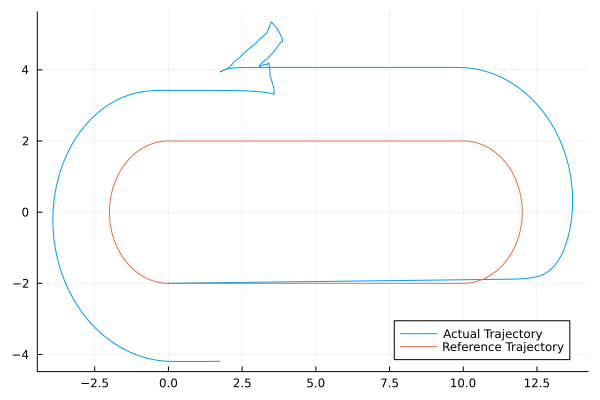

In [9]:
plot(traj_x_rect, traj_y_rect, label = "Actual Trajectory")
plot!(x_ref, y_ref, label = "Reference Trajectory")

TODO: Add discussion here

#### Circular Trajectory ####

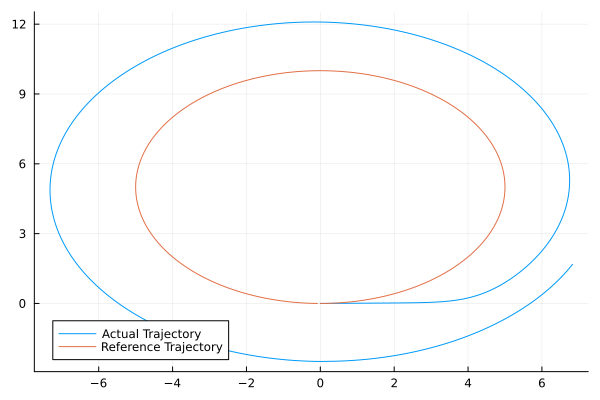

In [10]:
plot(traj_x_circle, traj_y_circle, label = "Actual Trajectory")
plot!(x_ref_circle, y_ref_circle, label = "Reference Trajectory")

TODO: Add discussion here

#### Sinusoidal Trajectory ####

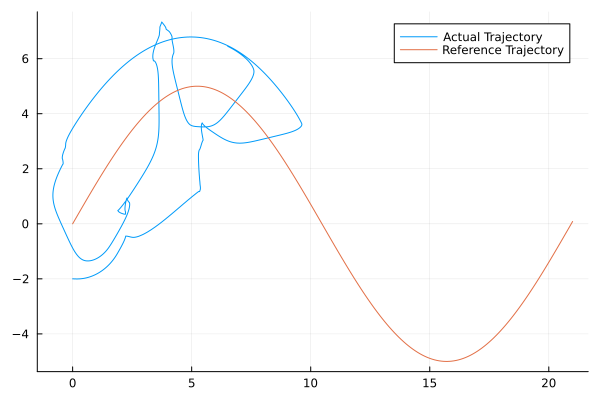

In [11]:
plot(traj_x_sin, traj_y_sin, label = "Actual Trajectory")
plot!(x_ref_sin, y_ref_sin, label = "Reference Trajectory")

TODO: Add discussion here

### MPC Evaluation ###

#### Rectangular Trajectory ###

#### Circular Trajectory ####

#### Sinusoidal Trajectory ####

#### Sinusoidal Trajectory with Obstacles ####

To solve the problem of finding a trajectory controller, and having it avoid obstacles, we started off with a PID controller on a bicycle model, modifying the bicycle model to fit the controller needs. However, the results did not look that great as seen in the above figure. Since a PID controller requires finding the right parameters (Kp and Kd in our case), it involves a lot of trial and error, and was complex to do all of it within Julia. We therefore decided to build on this work we had to further implement a MPC controller, which theoretically should provide much better results than a PID controller. 

## 5. Conclusion ##

Summarize your findings and your results, and talk about at least one possible future direction; something that might be interesting to pursue as a follow-up to your project.